# Drug ratings and reviews from patients: predicting overall rating using machine learning models for numerical and language processing methods

##### By Jeanna Schoonmaker, April 2020

### [Abstract](#abstract)

### [Introduction](#intro)

### [Part 1: Importing, exploring, and visualizing the drug datasets](#part_1)

### [Part 2: Linear regression on numeric data - using effectiveness and side effects ratings to predict overall rating](#part_2)

### [Part 3: Dataset modification and visualization - changing overall rating from numeric to boolean](#part_3)

### [Part 4: Logisic regression and confusion matrices on modified datasets](#part_4)

### [Part 5: Text processing to determine predictive nature of text responses](#part_5)

### [Conclusion](#conclusion)

### [Sources](#sources)

### [Addendums](#addendums)

<a id='abstract'></a>
# Abstract

### Using a drug review dataset gathered from online pharmaceutical websites, machine learning methods are employed on numerical data to determine if patient ratings given for efficacy and side effects have a linear relationship with overall rating, and whether univariate and multivariate logistic regression can accurately predict whether a patient's overall rating of a prescription drug will be positive or negative. Preprocessing, tf-idf vectorizing, ridge classification, and data visualization are used to analyze whether text review fields can accurately predict a positive or negative patient review. 

<a id='intro'></a>
# Introduction

Along with most major industries, healthcare continues to grow its digital footprint. With heightened concern about lessening face-to-face contact given the COVID-19 pandemic, more healthcare providers are offering and encouraging the use of tele-health options. Electronic healthcare records also continue to be implemented in hospitals and clinics across the United States. Additionally, online health sites contain a wealth of information about patient ratings of healthcare locations, providers, procedures, and experience with prescription drugs.

Using a dataset downloaded from the UCI Machine Learning Repository, I examined patient-submitted prescription drug reviews that include a drug name, the patient's condition, an effectiveness rating, a side effects rating, an overall rating on a 1-10 scale, and text comments about each of those ratings. Using machine learning techniques to analyze this data, it is hypothesized that:

* High effectiveness and minimal side effects will equal a high overall rating.
<br>

* A linear relationship will exist between efficacy ratings, side effect ratings, and the overall drug rating.
<br>


#### Questions to examine:

* Can side effect and effectiveness ratings accurately predict overall rating from 1 to 10?
<br>

* Can side effect and effectiveness ratings accurately predict whether overall rating is positive or negative?
<br>

* Can text reviews about a drug be processed to accurately predict whether a patient's overall rating is positive or negative?
<br>

#### Business use:
* Business use for this research includes a shortened ratings/review process for patients, possibly making it more likely they will participate, and resulting in more information being gleaned from fewer questions asked. Another possibility is determining if the text comments patients use to review their experience taking a drug can determine whether their experience was positive or negative, thus providing useful information for healthcare providers, pharmaceutical companies, insurers, as well as other patients, even when numeric ratings aren't available.

#### Dataset information and source:
The training and test datasets for this project came from: https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29, which states "The data was obtained by crawling online pharmaceutical review sites." Please note the publication cited (Felix Gräßer, Surya Kallumadi, Hagen Malberg, and Sebastian Zaunseder. 2018. Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data Learning. In Proceedings of the 2018 International Conference on Digital Health (DH '18). ACM, New York, NY, USA, 121-125. DOI: [Web Link]), is behind a paywall and was not reviewed before I began this project. It's possible that sections of my research repeat what the authors did. They do not mention language processing in their discussion of the data, however, nor do they mention modifying the data to simplify overall rating to a positive/negative value.

In [1]:
#Importing necessary libraries
import matplotlib.pyplot as plt
import matplotlib as mp
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import os
%matplotlib inline

<a id='part_1'></a>
# Part 1: Importing, exploring, and visualizing the drug datasets

In [2]:
#importing training data (already split in original downloads)
df = pd.read_csv(r'C:\Users\J\Desktop\Projects\drug.tsv', sep='\t')

In [3]:
#importing test data (already split in original downloads)
df_test = pd.read_csv(r'C:\Users\J\Desktop\Projects\drugtest.tsv', sep='\t')

In [4]:
#exploring the dataset
df.head()

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 9 columns):
Unnamed: 0           3107 non-null int64
urlDrugName          3107 non-null object
rating               3107 non-null int64
effectiveness        3107 non-null object
sideEffects          3107 non-null object
condition            3106 non-null object
benefitsReview       3107 non-null object
sideEffectsReview    3105 non-null object
commentsReview       3099 non-null object
dtypes: int64(2), object(7)
memory usage: 218.6+ KB
None


In [6]:
#number of unique drugs reviewed in dataset
names = df.urlDrugName.unique()
names.sort()

print(df.urlDrugName.nunique())

502


### To simplify working with the data, I converted both the effectiveness and side effect ratings to 5 point numeric scales, with 1 being negative for both scales ("extremely severe side effects" and "ineffective") and 5 being the most positive ("no side effects" and "highly effective").

In [7]:
#converting effectiveness and side effect responses to numeric 5 pt values for both training and test datasets
effectiveness_convert = {'Highly Effective': 5, 'Considerably Effective': 4, 'Moderately Effective': 3, 'Marginally Effective': 2, 'Ineffective': 1}
df['eff_number'] = df.effectiveness.apply(lambda x: effectiveness_convert[x])
df_test['eff_number'] = df_test.effectiveness.apply(lambda x: effectiveness_convert[x])
side_effects_convert = {'No Side Effects': 5, 'Mild Side Effects': 4, 'Moderate Side Effects': 3, 'Severe Side Effects': 2, 'Extremely Severe Side Effects': 1}
df['sideEffects_number'] = df.sideEffects.apply(lambda x: side_effects_convert[x])
df_test['sideEffects_number'] = df_test.sideEffects.apply(lambda x: side_effects_convert[x])

### To visualize the data, I created histograms to examine the distribution of rating combinations given for effectiveness, side effects, and overall rating.

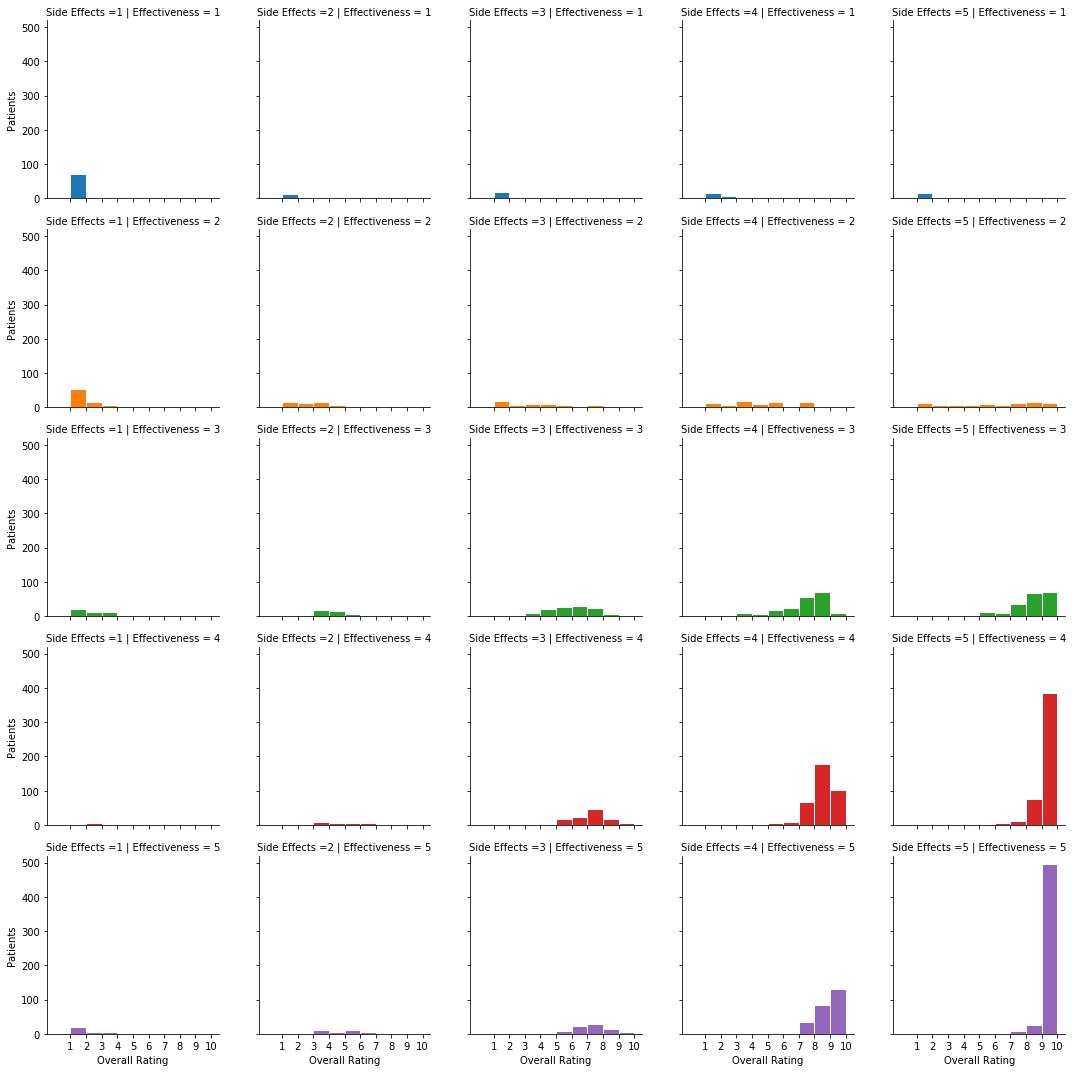

In [8]:
bins = np.arange(0, 11, 1)
g = sns.FacetGrid(df, col='eff_number',  row='sideEffects_number', hue='sideEffects_number')
g = (g.map(plt.hist, "rating", bins=bins, edgecolor='w')).set_axis_labels("Overall Rating", 'Patients').set(xticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).set_titles("Side Effects ={col_name} | Effectiveness = {row_name}")
g.savefig('fig1.png')

### If both side effects and effectiveness ratings are low (meaning a drug rated as ineffective with extremely severe side effects), overall ratings were also low, as seen in the upper left set of graphs.

### The middle row of graphs represents patients who rated a drug's side effects as 3, or "moderate" and show that if a drug's efficacy was also rated at 3 or above, patients' overall ratings were more likely to be positive.

### The 4th and 5th row of graphs represent patients who rated drug side effects as mild or non existent. When coupled with moderate, considerable, or highly effective ratings, we see the highest incidences of positive overall drug ratings, with the best possible scores for each leading to the highest spike in any of the plots (lower right). The next highest incidence of an overall rating of 10 is in the graph representing those who rated their drug with an effectiveness of 5 and a side effect level of 4, suggesting that patients are still happy with a drug regimen with mild side effects if it is also highly effective. 

<a id='part_2'></a>
# Part 2: Linear regression on numeric data - using effectiveness and side effects ratings to predict overall rating

In [9]:
#creating dataframe of columns needed for linear regression and visualization 
features = df.loc[:, ('urlDrugName', 'rating', 'eff_number', 'sideEffects_number', 'condition')]
features_test = df_test.loc[:, ('urlDrugName', 'rating', 'eff_number', 'sideEffects_number', 'condition')]

Coefficients for effectiveness rating, side effect rating:
[1.3581203  1.14264512]
Train score:
0.7394362692525084
Test score:
0.7531012716953546


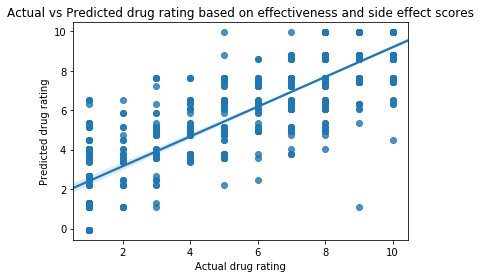

<Figure size 432x288 with 0 Axes>

In [10]:
X = features[['eff_number', 'sideEffects_number']]
y = features['rating']
X_test = features_test[['eff_number', 'sideEffects_number']]
y_test = features_test['rating']
lm = LinearRegression()
model = lm.fit(X, y)
print("Coefficients for effectiveness rating, side effect rating:")
print(lm.coef_)

y_predict = lm.predict(X_test)

print("Train score:")
print(lm.score(X, y))

print("Test score:")
print(lm.score(X_test, y_test))

sns.regplot(y_test, y_predict)
plt.ylabel('Predicted drug rating')
plt.xlabel('Actual drug rating')
plt.title('Actual vs Predicted drug rating based on effectiveness and side effect scores')

plt.show()
plt.savefig('fig2.png')

### As can be seen from the graph and stats above, when a linear regression is fit on the effectiveness and side effect ratings, it has an R^2 of .753 on the test data. There is a higher coefficient (1.358) for the effectiveness score and the overall rating vs. the side effect score and the overall rating (1.142). 

### Next, a boolean condition is implemented and each overall rating is determined to be either negative, for overall ratings of 1-5, or positive, with overall ratings of 6-10.

<a id='part_3'></a>
# Part 3: Dataset modification and visualization - changing overall rating from numeric to boolean

In [11]:
#converting overall ratings from 1-10 scale to 0 (negative) for ratings 1-5 and 1 (positive) for ratings 6-10 
rating_convert = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1}
df['rating_binary'] = df['rating'].apply(lambda x: rating_convert[x])
df_test['rating_binary'] = df_test['rating'].apply(lambda x: rating_convert[x])

### Exploring the training and test datasets with the positive/negative values added. First, a total count of the positive and negative values in both the training and testing data sets is observed. It is interesting to note that both datasets contain more than 2x as many positive reviews as negative. 

In [12]:
print(df['rating_binary'].value_counts())
print(df_test['rating_binary'].value_counts())

1    2287
0     820
Name: rating_binary, dtype: int64
1    728
0    308
Name: rating_binary, dtype: int64


In [13]:
#creating dataframes with only positive or negative ratings for visualization
df_negative = df.loc[:, ('eff_number', 'sideEffects_number', 'rating_binary', 'condition', 'urlDrugName')]
df_negative = df[df['rating_binary'] == 0]
df_positive = df.loc[:, ('eff_number', 'sideEffects_number', 'rating_binary', 'condition', 'urlDrugName')]
df_positive = df[df['rating_binary'] == 1]

### Next, I plotted bar graphs to explore the relationship between effectiveness and side effect ratings when the overall rating is either positive or negative.

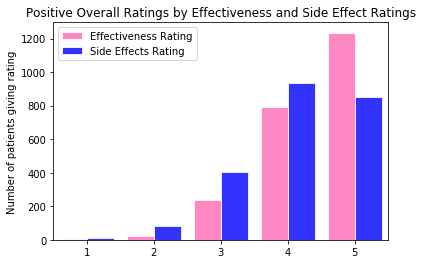

<Figure size 432x288 with 0 Axes>

In [14]:
#creating histogram of side effect and effectiveness ratings for positive reviews
X = df_positive['eff_number']
y = df_positive['sideEffects_number']

labels = ['Effectiveness Rating', 'Side Effects Rating']

plt.hist([X, y], color=['hotpink','b'], alpha=0.8, edgecolor='w', bins=np.arange(7)-0.5)
plt.ylabel('Number of patients giving rating')
plt.legend(labels)
plt.xlim([0.5, 5.5])
plt.title('Positive Overall Ratings by Effectiveness and Side Effect Ratings')
plt.show()
plt.savefig('fig3.png')

### Few positive overall ratings had side effect or effectiveness ratings lower than 3. Five is by far the most common effectiveness rating in positive overall ratings, while 4 is the most common side effect rating. 

### The graph below shows the effectiveness and side effect ratings associated with negative overall ratings. Note the variance in scale between the two graphs, with the y-axis for positive reviews reaching 1200 while the y-axis for negative reviews ends at 300. 


### Still, the negative rating graph shows that an effectiveness rating of 1 is the most common in negative reviews, while a side effect rating of 2 or 3 is more common than a side effect rating of 1. High ratings on side effects or ratings are uncommon, but not unseen even in patient reviews with negative overall ratings

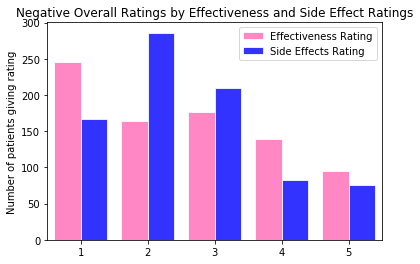

In [15]:
#creating histogram of side effect and effectiveness ratings in negative reviews
X = df_negative['eff_number']
y = df_negative['sideEffects_number']

labels = ['Effectiveness Rating', 'Side Effects Rating']

plt.hist([X, y], color=['hotpink','b'], alpha=0.8, edgecolor='w', bins=np.arange(7)-0.5)
plt.ylabel('Number of patients giving rating')
plt.legend(labels)
plt.xlim([0.5, 5.5])
plt.title('Negative Overall Ratings by Effectiveness and Side Effect Ratings')
plt.savefig('fig4.png')
plt.show()

<a id='part_4'></a>
# Part 4: Logisic regression and confusion matrices on pos/neg datasets

### First, I did a logistic regression with training and test data using only the effectiveness rating, then created a confusion matrix to show the results.

In [16]:
#creating logistic regression function for confusion matrix mapping
def lr_graph(X, X_test, title, y=df['rating_binary'], y_test=df_test['rating_binary']):
    lr = LogisticRegression(solver='liblinear', random_state=0)
    model = lr.fit(X,y)
    y_predict = model.predict(X_test)
    print('Train score:')
    print(model.score(X,y))
    print('Test score:')
    print(model.score(X_test, y_test))
    cm = confusion_matrix(y_test, y_predict)
    fig, ax = plt.subplots(figsize=(6, 6))
    cmap = mp.cm.rainbow
    ax.imshow(cm, cmap=cmap)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Negative Ratings', 'Predicted Positive Ratings'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Negatives', 'Actual Positives'))
    plt.title(title)
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='white', fontsize=24)
    plt.savefig(title + '.png')
    plt.show()

Train score:
0.859671709044094
Test score:
0.8397683397683398


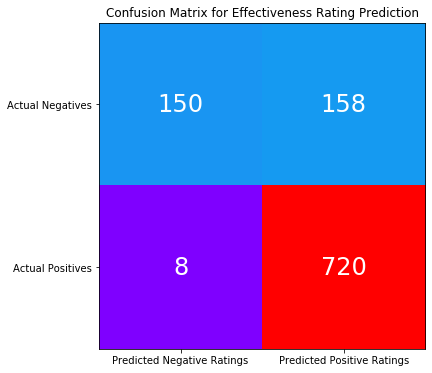

In [17]:
lr_graph(df[['eff_number']], df_test[['eff_number']], 'Confusion Matrix for Effectiveness Rating Prediction')

### The regression correctly identifies 150 actual negative reviews, with only 8 false negatives. However, while the regression correctly identifies 720 actual positive ratings, it erroneously identifies 158 reviews as positive that are actually negative. 

### Despite the number of false positives, the regression is 84% accurate on test data.

Train score:
0.8525909237206308
Test score:
0.8359073359073359


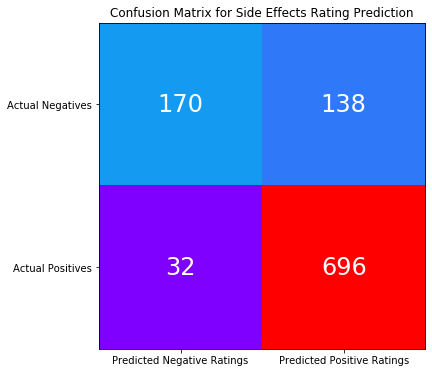

In [18]:
lr_graph(df[['sideEffects_number']], df_test[['sideEffects_number']], 'Confusion Matrix for Side Effects Rating Prediction')

### The side effect  results are very similar to the previous results, though this regression has more false negatives and fewer false positives. The regression accurately predicts whether the patient gave a positive or negative overall rating 84% of the time on the test data.

### Next, I ran a multivariate logistic regression using BOTH the effectiveness rating and side effect rating to predict whether the overall rating was positive or negative.

Train score:
0.9002252977148375
Test score:
0.88996138996139


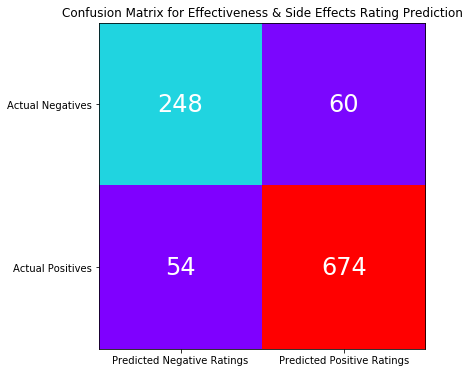

In [19]:
lr_graph(df[['eff_number', 'sideEffects_number']], df_test[['eff_number', 'sideEffects_number']], 'Confusion Matrix for Effectiveness & Side Effects Rating Prediction')

### Including both the effectiveness and side effect ratings in this regression led to a much lower incidence of false positives, but also the highest incidence of false negatives. 

### However, with an accuracy score of 89% on the test data, an overall positive or negative rating could be accurately predicted the majority of the time using only a patient's ratings for a drug's effectiveness and side effects.

<a id='part_5'> </a>
# Part 5: Text processing to determine predictive accuracy of text responses

### With text comments being an important part of most online reviews, utilizing text data to determine whether a patient's rating of a drug is positive or negative could provide valuable feedback to other patients, healthcare providers, pharmacists, insurers, and prescription drug manufacturers. 

### According to analysis done in addendums 1-3, using a Ridge Classifier model yields slightly better results than logistic regression for this text analysis. A tf-idf bigram model also performed better than a bag of words model.

In [27]:
#import necessary libraries for natural language processing, create processing functions, instantiate tfidf vector
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.linear_model import RidgeClassifierCV
from sklearn.feature_extraction.text import CountVectorizer
import string

stop = stopwords
ps = PorterStemmer()

def preprocessor(text):
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = str(text)
    text = text.translate(t)
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    return text

def port(text):
    return [ps.stem(word) for word in text]

tfidf = TfidfVectorizer(strip_accents=None,
                        max_df=0.90,
                        ngram_range=(1, 2))     

counter = CountVectorizer()

In [28]:
#create dataframe with text and label info
dftext = df.loc[:, ('benefitsReview', 'sideEffectsReview', 'commentsReview', 'rating_binary')]
dftext.head(5)

,benefitsReview,sideEffectsReview,commentsReview,rating_binary
0,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ...",0
1,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest...",0
2,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...,1
3,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...,0
4,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above,0


### Please note that in both the training and test datasets, there are 3 fields with text reviews: benefitsReview, sideEffectsReview, and commentsReview. Analysis will be done on all 3 individual review fields, and then on the full corpus of review text.

In [29]:
#create test dataframe with text and label info
dftext_test = df_test.loc[:, ('benefitsReview', 'sideEffectsReview', 'commentsReview', 'rating_binary')]
dftext_test.head(5)

,benefitsReview,sideEffectsReview,commentsReview,rating_binary
0,The antibiotic may have destroyed bacteria cau...,"Some back pain, some nauseau.",Took the antibiotics for 14 days. Sinus infect...,1
1,Lamictal stabilized my serious mood swings. On...,"Drowsiness, a bit of mental numbness. If you t...",Severe mood swings between hypomania and depre...,1
2,Initial benefits were comparable to the brand ...,"Depakene has a very thin coating, which caused...",Depakote was prescribed to me by a Kaiser psyc...,0
3,It controlls my mood swings. It helps me think...,I didnt really notice any side effects.,This drug may not be for everyone but its wond...,1
4,Within one week of treatment superficial acne ...,Side effects included moderate to severe dry s...,Drug was taken in gelatin tablet at 0.5 mg per...,1


In [30]:
#creating empty lists for processed text reviews
benefits = []
test_benefits = []
effects = []
test_effects = []
comments = []
test_comments = []

#function for processing text reviews, with if/else split on whether the data is part of the training or test set
def process(text_review_field, converted_reviews_name):
    if len(text_review_field) > 3000:
        dftext2 = dftext.assign(temp = text_review_field.values)
        textvalues = dftext2['temp'].apply(preprocessor)
        textvalues = port(textvalues)
        converted_reviews_name += textvalues
    else:
        dftext_test2 = dftext_test.assign(temp = text_review_field.values)
        textvalues = dftext_test2['temp'].apply(preprocessor).values
        textvalues = port(textvalues)
        converted_reviews_name += textvalues
    return converted_reviews_name

#data to be used in process function to populate empty text reviews lists
review_fields = [dftext['benefitsReview'], dftext_test['benefitsReview'], dftext['sideEffectsReview'], dftext_test['sideEffectsReview'], dftext['commentsReview'], dftext_test['commentsReview']]
review_field_names = [benefits, test_benefits, effects, test_effects, comments, test_comments]

#running the process function on each text field and appending processed text reviews to text review lists
for review, reviewlist in zip(review_fields, review_field_names):
    process(review, reviewlist)

In [31]:
 #concatenating all text review fields into one and modifying ratings fields to match for use in analysis of complete corpus
all_comments = benefits + effects + comments
all_test = test_benefits + test_effects + test_comments
ratings = df['rating_binary'].tolist()
ratings = ratings *3
ratings_test = df_test['rating_binary'].tolist()
ratings_test = ratings_test * 3

In [32]:
#creating empty list for storing model accuracy scores for final analysis
model_list = []

#creating ridge classifier function for confusion matrix mapping
def rc_graph(X, X_test, title, y=df['rating_binary'], y_test=df_test['rating_binary']):
    rc = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1])
    model = rc.fit(X,y)
    y_predict = model.predict(X_test)
    print('Train score:')
    print(model.score(X,y))
    print('Test score:')
    score = model.score(X_test, y_test)
    model_list.append(score)
    print(score)
    cm = confusion_matrix(y_test, y_predict)
    fig, ax = plt.subplots(figsize=(6, 6))
    cmap = mp.cm.rainbow
    ax.imshow(cm, cmap=cmap)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Negative Ratings', 'Predicted Positive Ratings'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Negatives', 'Actual Positives'))
    plt.title(title)
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='white', fontsize=24)
    plt.savefig(title + '.png')
    plt.show()

### Confusion Matrix for Benefits Reviews Ridge Classifier

Train score:
0.990344383649823
Test score:
0.7760617760617761


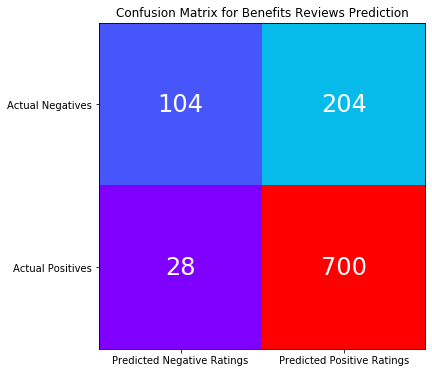

In [33]:
#running tf-idf on benefits review field
vector1 = tfidf.fit_transform(benefits)
vector1_test = tfidf.transform(test_benefits)

rc_graph(vector1, vector1_test, 'Confusion Matrix for Benefits Reviews Prediction')

### Confusion Matrix for Side Effects Reviews Ridge Classifier

Train score:
0.9826198905696814
Test score:
0.7944015444015444


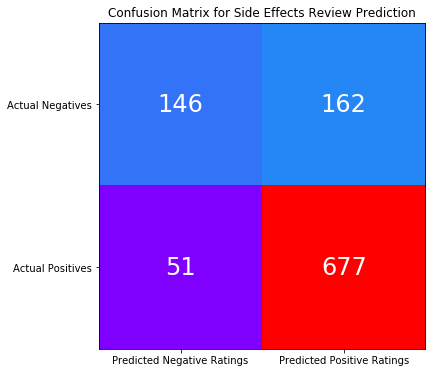

In [34]:
vector2 = tfidf.fit_transform(effects)
vector2_test = tfidf.transform(test_effects)

rc_graph(vector2, vector2_test, 'Confusion Matrix for Side Effects Review Prediction')

### Confusion Matrix for Comments Ridge Classifier

Train score:
0.9777920823945928
Test score:
0.752895752895753


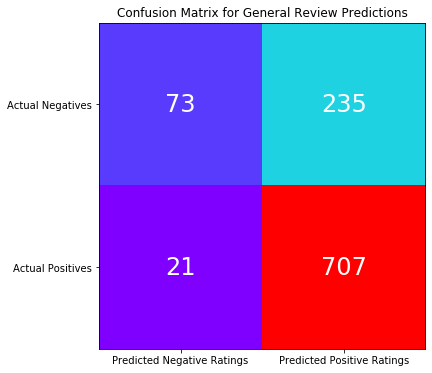

In [35]:
vector3 = tfidf.fit_transform(comments)
vector3_test = tfidf.transform(test_comments)

rc_graph(vector3, vector3_test, 'Confusion Matrix for General Review Predictions')

### Confusion Matrix for full corpus of all text review fields

Train score:
0.9741444051067482
Test score:
0.7673745173745173


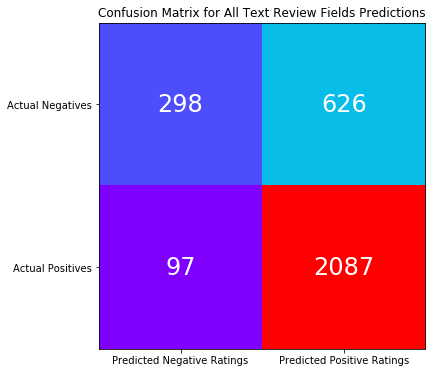

In [36]:
vector4 = tfidf.fit_transform(all_comments)
vector4_test = tfidf.transform(all_test)

rc_graph(vector4, vector4_test, 'Confusion Matrix for All Text Review Fields Predictions', ratings, ratings_test)

### Model Accuracy Scores

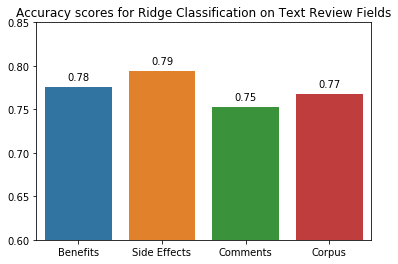

,Model,Accuracy
0,Benefits,0.776062
1,Side Effects,0.794402
2,Comments,0.752896
3,Corpus,0.767375


<Figure size 432x288 with 0 Axes>

In [38]:
#creating bar graph and dataframe of each text review field's confusion matrix and its score

X = ['Benefits', 'Side Effects', 'Comments', 'Corpus']

model_df = pd.DataFrame(zip(X, model_list), columns=['Model', 'Accuracy'])

g = sns.barplot(X, model_list)
plt.ylim(0.6, 0.85)
plt.title('Accuracy scores for Ridge Classification on Text Review Fields')
for p in g.patches:
    g.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()
plt.savefig('modelaccuracy.png')
model_df

### The reviews written about side effects were the most predictive, at 79%. The benefits review field accurately predicted whether a patient gave a negative or positive rating in 78% of the results. All of the text fields joined together had a 77% accuracy score, while the comments section was the lowest, at 75%.

### In every classification, the number of false positives was higher than the number of actual negatives, sometimes by a significant percentage.

<a id='conclusion'></a>

# Conclusions

1. Linear regression showed that as patients' ratings of efficacy and side effects went up, the patient's overall rating for the drug was also likely to increase, and had an R^2 value of 75%, indicating a relatively good fit.
<br>
    
2. The effectiveness rating was more predictive of the overall rating than the side effect rating, as shown in the coefficients of 1.36 for effectiveness and 1.14 for side effects. This suggests a patient taking a drug will more heavily weight the effectiveness of the drug when determining its overall rating than the side effects they experience while taking it.
<br>

* Data visualization after changing the overall rating to either positive or negative showed wider variance in negative ratings, as patients rated side effect or efficacy all along the 1-5 range, while the overall positive ratings had very few or no low ratings for side effects or efficacy.
<br>

3. After converting overall rating of 1-10 to either negative (1-5) or positive (6-10), a logistic regression on the efficacy and side effect ratings alone could accurately predict whether the overall rating was positive or negative with 84% accuracy. Combining the two led to an even stronger result, with an 89% accuracy in predicting a pos/neg rating. False positives were the most common error when using logistic regression classification. 
<br>

4. This suggests an online review could be shortened to just include efficacy and side effect ratings and nearly 90% of the time, it would still accurately predict whether a patient's overall rating of a drug would be positive or negative. Taking this into account, pharmaceutical companies could shorten their online ratings process, possibly increasing the number of respondents and giving a clearer overall picture of whether the majority of patients have a positive or negative experience on a certain drug. 
<br>

5. Despite tuning hyperparameters, including populating both a bag of words and tf-idf model, and comparing outputs of ridge, perceptron, KNN, random forest, SVC, SGD, and naive bayes classifiers, the most accurate classification on the text fields of the drug reviews was 79%, from the side effects text review field. The benefits text reviews were 78% accurate, while the comments only correctly predicted a positive or negative rating 75% of the time. Using the full corpus was 77% accurate. A tf-idf bigram model and ridge classifer were chosen for all text fields, as they gave consistently high outputs, but training data showed as 97-99% accurate, suggesting that overfitting occurred. False positives were significant in all text review classifications.
<br>
    
6. Unique challenges associated with text processing of prescription drug reviews, and likely other health related data, include:
<ul> a. Medical jargon that leads to sparse features when vectorizing</ul>
<ul> b. Patients misspelling drug and condition names</ul>
<ul> c. Heavy usage of numbers in reviews, such as dosing regimens, that may or may not be useful or dependable as features</ul>
<ul> d. By nature of sharing information about why they are taking a drug, patients' comments may include negative commentary on their condition, while their comments about the drug itself are positive, which could be difficult for a machine learning algorithm to accurately identify</ul>
<br>

7. Even with these challenges, nearly 80% accuracy in predicting a positive or negative rating from the content of the text fields shows that prediction using text reviews has great potential.
<br>

* The training dataset had over 500 unique prescription drugs reviewed. In future studies, focusing on one drug, or perhaps one condition, might result in better language processing accuracy, as side effects and common concerns are more likely to be repeated. 
<br>

* Future projects might also ensure a better balance of positive and negative reviews in the training and test data set.
<br>

* In the current environment of increased tele-health and remote healthcare options, electronic healthcare records, as well as the continuing growth of online discussions of health related issues, robust processing options for healthcare-related language would serve an important role.

<a id='sources'></a>
# Sources

1. Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011. Machine learning libraries

2. https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29 Datasets

3. https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py¶ - used as template for measuring accuracy of classification models as seen in addendums

<a id='addendums'></a>
## Addendum 1 - classification of all text comments using Bag of Words model

### Scikit learn classification example used as template (see <a id='sources'>sources</a> #3)

In [39]:
import logging
from optparse import OptionParser
import sys
from time import time
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

In [40]:
def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')

op = OptionParser()
op.add_option("--report",
              action="store_true", dest="print_report",
              help="Print a detailed classification report.")
op.add_option("--chi2_select",
              action="store", type="int", dest="select_chi2",
              help="Select some number of features using a chi-squared test")
op.add_option("--confusion_matrix",
              action="store_true", dest="print_cm",
              help="Print the confusion matrix.")

argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

X_train = counter.fit_transform(all_comments)
y_train = ratings
X_test = counter.transform(all_test)
y_test = ratings_test

def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None, solver='sag',
                tol=0.01)
train time: 0.202s
test time:  0.001s
accuracy:   0.743

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.031s
test time:  0.000s
accuracy:   0.694

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                        

C:\Users\J\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


test time:  1.087s
accuracy:   0.675

Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


C:\Users\J\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train time: 1.028s
test time:  0.015s
accuracy:   0.723

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
          verbose=0)
train time: 1.218s
test time:  0.001s
accuracy:   0.707

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.061s
test time:  0.000s
a

C:\Users\J\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


train time: 0.621s
test time:  0.001s
accuracy:   0.712

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
              n_iter_no_change=5, n_jobs=None, penalty='l1', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.197s
test time:  0.001s
accuracy:   0.703

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
              n_iter_no_change=5, n_jo

C:\Users\J\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Creating dataframe listing classification model and its accuracy on given dataset. Ridge Classification using tf-idf processing was chosen for the project, as it consistently gave top results

In [41]:
d=[]
for each in results:
    d.append({'Model': each[0], 'Accuracy': each[1]})
dfmodel = pd.DataFrame(data=d)
dfmodel

,Model,Accuracy
0,RidgeClassifier,0.742600
1,Perceptron,0.693694
2,PassiveAggressiveClassifier,0.699163
3,KNeighborsClassifier,0.675354
4,RandomForestClassifier,0.723295
5,LinearSVC,0.707207
6,SGDClassifier,0.734878
7,LinearSVC,0.712355
8,SGDClassifier,0.703346
9,SGDClassifier,0.731660


### Addendum 2 - classification of all text review comments using Tf-Idf model

In [42]:
X_train = tfidf.fit_transform(all_comments)
y_train = ratings
X_test = tfidf.transform(all_test)
y_test = ratings_test

results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None, solver='sag',
                tol=0.01)
train time: 0.227s
test time:  0.001s
accuracy:   0.767

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.026s
test time:  0.001s
accuracy:   0.729

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                        

C:\Users\J\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train time: 3.266s
test time:  0.039s
accuracy:   0.719

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
          verbose=0)
train time: 0.258s
test time:  0.001s
accuracy:   0.765

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.065s
test time:  0.001s
a

In [43]:
d=[]
for each in results:
    d.append({'Model': each[0], 'Accuracy': each[1]})
dfmodel = pd.DataFrame(data=d)
dfmodel

,Model,Accuracy
0,RidgeClassifier,0.766731
1,Perceptron,0.728764
2,PassiveAggressiveClassifier,0.746782
3,KNeighborsClassifier,0.703346
4,RandomForestClassifier,0.719112
5,LinearSVC,0.765444
6,SGDClassifier,0.768018
7,LinearSVC,0.758044
8,SGDClassifier,0.736165
9,SGDClassifier,0.747748


### Addendum 3 - classification of benefitsReview text field with tf-idf

In [44]:
X_train = tfidf.fit_transform(benefits)
y_train = dftext['rating_binary']
X_test = tfidf.transform(test_benefits)
y_test = dftext_test['rating_binary']

results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None, solver='sag',
                tol=0.01)
train time: 0.076s
test time:  0.001s
accuracy:   0.776

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.006s
test time:  0.001s
accuracy:   0.770

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                        

C:\Users\J\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train time: 0.371s
test time:  0.006s
accuracy:   0.738

L2 penalty
________________________________________________________________________________
Training: 
LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
          verbose=0)
train time: 0.042s
test time:  0.000s
accuracy:   0.774

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.025s
test time:  0.000s
a

In [45]:
d=[]
for each in results:
    d.append({'Model': each[0], 'Accuracy': each[1]})
dfmodel = pd.DataFrame(data=d)
dfmodel

,Model,Accuracy
0,RidgeClassifier,0.776062
1,Perceptron,0.770270
2,PassiveAggressiveClassifier,0.777027
3,KNeighborsClassifier,0.739382
4,RandomForestClassifier,0.738417
5,LinearSVC,0.774131
6,SGDClassifier,0.781853
7,LinearSVC,0.769305
8,SGDClassifier,0.776062
9,SGDClassifier,0.776062
